<a href="https://colab.research.google.com/github/hyeonjun/boostcourse_tensorflow/blob/master/lab_12_3_many_to_many_keras_eager.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# many to many

simple pos-targger training
- many to many
- variable input sequence length

Example : part of speech tagging
- Preparing dataset
- Creating and training model
- Checking performance

자연어 처리에서 개체명 인식 또는 형태소 분석과 같은 시퀀스 태깅을 모델링하는데 활용할 수 있다.

many to many는 RNN이 시퀀스를 구성하고 있는 각각의 토큰에 대해 모두 출력을 내어주는 구조.

setence를 word 단위로 tokenization 한 뒤,
이러한 토큰으로 이루어진 시퀀스를 RNN이 각각의 토큰을 읽고 해당 토큰이 어떤 품사인지 파악하는 방식으로 many to many를 활용할 수 있다.

토큰인 word는 숫자가 아니기 때문에 Embedding layer를 이용하여 RNN이 처리할 수 있도록 numeric vector로 변환해야 한다.

이렇게 numeric vector로 변환된 토큰을 RNN이 각각의 토큰ㅇ르 순서대로 읽을 때마다 토큰에 대한 출력을 내고 이를 정답과 비교하여 토큰마다 loss를 계산한다.

그리고 모든 토큰에 대해 계산된 loss의 평균을 낸다(sequence loss)

이 sequence loss를 RNN을 back propagation을 통해서 학습할 수 있다.




In [ ]:
# setup
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pprint import pprint
%matplotlib inline

In [ ]:
# Preparing dataset
# example data
# 문장
sentences = [['I', 'feel', 'hungry'],
     ['tensorflow', 'is', 'very', 'difficult'],
     ['tensorflow', 'is', 'a', 'framework', 'for', 'deep', 'learning'],
     ['tensorflow', 'is', 'very', 'fast', 'changing']]
# 품사
pos = [['pronoun', 'verb', 'adjective'],
     ['noun', 'verb', 'adverb', 'adjective'],
     ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
     ['noun', 'verb', 'adverb', 'adjective', 'verb']]

In [ ]:
# Preprocessing dataset
# creating a token dictionary for word
word_list = sum(sentences, [])
word_list = sorted(set(word_list))
word_list = ['<pad>']+word_list # 입력과 출력의 같음을 표현하기 위해 pad 토큰 포함
word2idx = {word : idx for idx, word in enumerate(word_list)}
idx2word = {idx : word for idx, word in enumerate(word_list)}

print(word2idx)
print(idx2word)
print(len(idx2word))

{'<pad>': 0, 'I': 1, 'a': 2, 'changing': 3, 'deep': 4, 'difficult': 5, 'fast': 6, 'feel': 7, 'for': 8, 'framework': 9, 'hungry': 10, 'is': 11, 'learning': 12, 'tensorflow': 13, 'very': 14}
{0: '<pad>', 1: 'I', 2: 'a', 3: 'changing', 4: 'deep', 5: 'difficult', 6: 'fast', 7: 'feel', 8: 'for', 9: 'framework', 10: 'hungry', 11: 'is', 12: 'learning', 13: 'tensorflow', 14: 'very'}
15


In [ ]:
# creating a token dictionary for part of speech
pos_list = sum(pos, [])
pos_list = sorted(set(pos_list))
pos_list = ['<pad>']+pos_list # 입력과 출력의 같음을 표현하기 위해 pad 토큰 포함
pos2idx = {pos : idx for idx, pos in enumerate(pos_list)}
idx2pos = {idx : pos for idx, pos in enumerate(pos_list)}

print(pos2idx)
print(idx2pos)
print(len(pos2idx))

{'<pad>': 0, 'adjective': 1, 'adverb': 2, 'determiner': 3, 'noun': 4, 'preposition': 5, 'pronoun': 6, 'verb': 7}
{0: '<pad>', 1: 'adjective', 2: 'adverb', 3: 'determiner', 4: 'noun', 5: 'preposition', 6: 'pronoun', 7: 'verb'}
8


In [ ]:
# converting sequence of tokens to sequence of indices
max_sequence = 10
# 토큰 딕셔너리를 기반으로 word의 시퀀스를 integer index의 시퀀스로 변환
x_data = list(map(lambda sentence : [word2idx.get(token) for token in sentence], sentences))
# 품사도 마찬가지로 변환
y_data = list(map(lambda sentence : [pos2idx.get(token) for token in sentence], pos))

# padding the sequence of indices
# pad_sequences function을 이용하여 max_sequence의 값만큼의 길이로 padding
x_data = pad_sequences(sequences=x_data, maxlen=max_sequence, padding='post')
# padding한 부분에 대한 마스킨 정보를 담고 있는 x_data_mask
x_data_mask = ((x_data != 0) * 1).astype(np.float32)
# 각각의 sentence가 몇 개의 word로 tokenization이 됐는지 계산한 sentence에 유효한  길이
x_data_len = list(map(lambda sentence : len(sentence), sentences))


y_data = pad_sequences(sequences=y_data, maxlen=max_sequence, padding='post')

# checking data
print(x_data, x_data_len)
print(x_data_mask)
print(y_data)

[[ 1  7 10  0  0  0  0  0  0  0]
 [13 11 14  5  0  0  0  0  0  0]
 [13 11  2  9  8  4 12  0  0  0]
 [13 11 14  6  3  0  0  0  0  0]] [3, 4, 7, 5]
[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]]
[[6 7 1 0 0 0 0 0 0 0]
 [4 7 2 1 0 0 0 0 0 0]
 [4 7 3 4 5 1 4 0 0 0]
 [4 7 2 1 7 0 0 0 0 0]]


In [ ]:
# Creating model
# creating rnn for "many to many" sequence tagging
num_classes = len(pos2idx)
hidden_dim=10
input_dim=len(word2idx)
output_dim=len(word2idx)
one_hot = np.eye(len(word2idx))

model = Sequential()
# Embedding layer의 경우 토큰을 one hot venctor로 표현하고, 학습은 시키지 않는다.
# 0으로 padding된 부분을 연산에서 제외하는 방식으로 활용
model.add(layers.Embedding(input_dim=input_dim, output_dim=output_dim, mask_zero=True,
                           trainable=False, input_length=max_sequence, embeddings_initializer=keras.initializers.Constant(one_hot)))
# Embedding layer 이외에는 Simple RNN을 return_sequences=True 옵션을 줘서 활용
# RNN이 있는 모든 토큰에 대해서 출력을 내줘야하기 때문.
model.add(layers.SimpleRNN(units=hidden_dim, return_sequences=True))
# TImeDistributed와 Dense를 이용.
# 매 토큰마다 품사가 무엇인지 classification을 하는 형태로 RNN을 many to many 방식으로
# 활용하는 구조를 완성할 수 있다.
model.add(layers.TimeDistributed(layers.Dense(units=num_classes)))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 15)            225       
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 10, 10)            260       
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 8)             88        
Total params: 573
Trainable params: 348
Non-trainable params: 225
_________________________________________________________________


In [ ]:
# Training model
# creating loss Function 모델의 출력과 결과를 비교.
# 매 토큰마다 loss를 계산해야하고 특히 pad 토큰에 대한 부분은 loss에 반영하면 안된다.
# 그래서 실제 시퀀스에 유효한 길이와 max_sequence를 받아 마스킹을 생성하고
# 이를 mini batch loss에 반영하는 형태로 loss function을 구현한다.
def loss_fn(model, x, y, x_len, max_sequence):
  masking = tf.sequence_mask(x_len, maxlen=max_sequence, dtype=tf.float32)
  valid_time_step=tf.cast(x_len, dtype=tf.float32)
  sequence_loss = tf.keras.losses.sparse_categorical_crossentropy(
      y_true=y, y_pred=model(x), from_logits=True) * masking
  sequence_loss = tf.reduce_sum(sequence_loss, axis=-1) / valid_time_step
  sequence_loss = tf.reduce_mean(sequence_loss)
  return sequence_loss

# creating and optimizer
lr = 0.1
epochs = 30
batch_size = 2 
opt = tf.keras.optimizers.Adam(learning_rate = lr)

In [ ]:
# generating data pipeline
tr_dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data, x_data_len))
tr_dataset = tr_dataset.shuffle(buffer_size=4)
tr_dataset = tr_dataset.batch(batch_size = 2)

print(tr_dataset)

<BatchDataset shapes: ((None, 10), (None, 10), (None,)), types: (tf.int32, tf.int32, tf.int32)>


In [ ]:
# training
tr_loss_hist = []

for epoch in range(epochs):
  avg_tr_loss = 0
  tr_step = 0

  for x_mb, y_mb, x_mb_len in tr_dataset:
    with tf.GradientTape() as tape: # mini batch마다의 시퀀스 loss를 계산
      # 시퀀스의 유효한 길이(x_len)와 max_sequence를 인풋으로 받고있음
      tr_loss = loss_fn(model, x=x_mb, y=y_mb, x_len=x_mb_len, max_sequence=max_sequence)
    grads = tape.gradient(target=tr_loss, sources=model.variables) # Gradient 계산
    opt.apply_gradients(grads_and_vars=zip(grads, model.variables)) # Gradient Descent
    avg_tr_loss += tr_loss
    tr_step += 1
  if (epoch + 1) %5 == 0:
    print('epoch : {:3}, tr_loss : {:.3f}'.format(epoch +1, avg_tr_loss))
  else:
    avg_tr_loss /= tr_step
    tr_loss_hist.append(avg_tr_loss)

epoch :   5, tr_loss : 0.397
epoch :  10, tr_loss : 0.017
epoch :  15, tr_loss : 0.004
epoch :  20, tr_loss : 0.002
epoch :  25, tr_loss : 0.001
epoch :  30, tr_loss : 0.001


In [ ]:
# Checking performance
yhat = model.predict(x_data)
yhat = np.argmax(yhat, axis=-1) * x_data_mask

# pad 토큰이 추가되었는데 이는 모델을 batch 단위 연산으로 트레이닝하기 위해서
# 입력과 출력의 시퀀스에 pad 토큰을 이용하여 padding했기 때문.
pprint(list(map(lambda row : [idx2pos.get(elm) for elm in row],yhat.astype(np.int32).tolist())), width=120)
pprint(pos)

[['pronoun', 'verb', 'adjective', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'],
 ['noun', 'verb', 'adverb', 'adjective', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'],
 ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun', '<pad>', '<pad>', '<pad>'],
 ['noun', 'verb', 'adverb', 'adjective', 'verb', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']]
[['pronoun', 'verb', 'adjective'],
 ['noun', 'verb', 'adverb', 'adjective'],
 ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
 ['noun', 'verb', 'adverb', 'adjective', 'verb']]


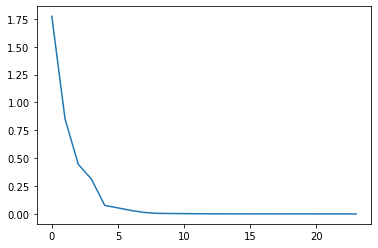

In [ ]:
plt.plot(tr_loss_hist)